In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
import gc
#import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer
import nltk
from nltk.tokenize import TweetTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
!pip install kaggle


In [ ]:
import pandas as pd
traindf = pd.read_csv('/content/hate_speech_dataset_sample(size 10).csv', encoding='latin1')
print(traindf.shape[0])
traindf.head(5)

10


,id,text,HS,AG,TR
0,1,I'm so tired of these immigrants coming here a...,1,1,1
1,2,I love the diversity in this city.,0,0,0
2,3,These people should just go back to their own ...,1,1,1
3,4,What a beautiful day! #blessed,0,0,0
4,5,Why do they always act so entitled? Unbelievable.,1,1,0


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence

class BERT_LSTM_Model(nn.Module):

  def __init__(self, bert, n_class):
    dropout_rate = 0.2
    lstm_hidden_size = None

    super(BERT_LSTM_Model, self).__init__()
    self.bert = bert

    if not lstm_hidden_size:
      self.lstm_hidden_size = self.bert.config.hidden_size
    else:
      self.lstm_hidden_size = lstm_hidden_size
    self.n_class = n_class
    self.dropout_rate = dropout_rate
    self.lstm = nn.LSTM(self.bert.config.hidden_size, self.lstm_hidden_size, bidirectional=True)
    self.hidden_to_softmax = nn.Linear(self.lstm_hidden_size * 2, n_class, bias=True)
    self.dropout = nn.Dropout(p=self.dropout_rate)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask):
    encoded_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)[2] #,output_all_encoded_layers=False)   #output_hidden_states output_hidden_states=True
    bert_hidden_layer = encoded_layers[12]
    bert_hidden_layer = bert_hidden_layer.permute(1, 0, 2)   #permute rotates the tensor. if tensor.shape = 3,4,5  tensor.permute(1,0,2), then tensor,shape= 4,3,5  (batch_size, sequence_length, hidden_size)

    sents_lengths = [36 for i in range(len(sent_id))]
    enc_hiddens, (last_hidden, last_cell) = self.lstm(pack_padded_sequence(bert_hidden_layer, sents_lengths, enforce_sorted=False)) #enforce_sorted=False  #pack_padded_sequence(data and batch_sizes
    output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)  # (batch_size, 2*hidden_size)
    output_hidden = self.dropout(output_hidden)
    pre_softmax = self.hidden_to_softmax(output_hidden)

    return self.softmax(pre_softmax)


# class BERT_LSTM_Model(nn.Module):
#     def __init__(self, bert, n_class):
#         super(BERT_LSTM_Model, self).__init__()
#         self.bert = bert
#         self.lstm = nn.LSTM(self.bert.config.hidden_size, self.bert.config.hidden_size, bidirectional=True)
#         self.hidden_to_softmax = nn.Linear(self.bert.config.hidden_size * 2, n_class, bias=True)
#         self.dropout = nn.Dropout(p=0.1)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, sent_id, mask):
#         outputs = self.bert(sent_id, attention_mask=mask)
#         bert_hidden_layer = outputs.last_hidden_state
#         bert_hidden_layer = bert_hidden_layer.permute(1, 0, 2)
#         enc_hiddens, (last_hidden, last_cell) = self.lstm(bert_hidden_layer)
#         output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
#         output_hidden = self.dropout(output_hidden)
#         pre_softmax = self.hidden_to_softmax(output_hidden)
#         return self.softmax(pre_softmax)

In [ ]:
def read_dataset(ty):

    train_labels = traindf[ty]

    return traindf['text'].tolist(), train_labels


def tokenize(tweet):
    # instantiate the tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,
                              strip_handles=True,
                              reduce_len=True)

    # tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens: # Go through every word in your tokens list
        if word not in string.punctuation:  # remove punctuation
            tweets_clean.append(word)
    result = tweets_clean
    return " ".join(result)

emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

def preprocess(tweet):
    result = tweet.replace('rt @','@')
    result = result.replace('@','<user> @')
    # it will remove hyperlinks
    result = re.sub(r'https?:\/\/.*[\r\n]*', '<url>', result)

    # it will remove hashtags. We have to be careful here not to remove
    # the whole hashtag because text of hashtags contains huge information.
    # only removing the hash # sign from the word
    result = re.sub(r'#', '<hashtag>', result)

    # Replace multiple dots with space
    result = re.sub('\.\.+', ' ', result)



    for char in result:
        if emoji.is_emoji(char):
            result = result.replace(char, "<emoticon >")
    for emo in emoticons:
        result = result.replace(emo, "<emoticon >")

    result = tokenize(result)
    # it will remove single numeric terms in the tweet.
    result = re.sub(r'[0-9]+', '<number>', result)
    result = re.sub(r'<number>\s?st', '<number>', result)
    result = re.sub(r'<number>\s?nd', '<number>', result)
    result = re.sub(r'<number>\s?rd', '<number>', result)
    result = re.sub(r'<number>\s?th', '<number>', result)

    return result

def pre_process_dataset(values):
    new_values = list()
    for value in values:
        new_values.append(preprocess(value.lower()))
#     print(values[:5])
#     print(new_values[:5])
    return new_values

In [ ]:
def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

In [ ]:
def load_and_process(ty):

    data, labels = read_dataset(ty)
#     num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels

In [ ]:
# function to train the model
def train(model,optimizer,train_dataloader,batch_size):
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        labels_tensor = labels.clone().detach().to(device).long()
        loss = cross_entropy(preds, labels_tensor)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate(model,val_dataloader,batch_size):
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)


            labels_tensor = labels.clone().detach().to(device).long()
            loss = cross_entropy(preds, labels_tensor)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

cpu


In [ ]:

# def modelss(ty):

#     # Load Dataset
#     input_ids, attention_masks, labels = load_and_process(ty)
#     df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

#     # Class distribution
#     train_text, val_text, train_labels, val_labels = train_test_split(df, labels, test_size=0.1, random_state=42)

#     gc.collect()
#     torch.cuda.empty_cache()

#     train_count = len(train_labels)
#     val_count = len(val_labels)


#     # for train set
#     train_seq = torch.tensor(train_text['input_ids'].tolist())
#     train_mask = torch.tensor(train_text['attention_masks'].tolist())
#     train_y = torch.tensor(train_labels.astype(int))

#     # for validation set
#     val_seq = torch.tensor(val_text['input_ids'].tolist())
#     val_mask = torch.tensor(val_text['attention_masks'].tolist())
#     val_y = torch.tensor(val_labels.astype(int))



#     # define a batch size
#     batch_size = 32
#     learning_rate = 3e-5

#     # wrap tensors
#     train_data = TensorDataset(train_seq, train_mask, train_y)
#     # sampler for sampling the data during training
#     train_sampler = RandomSampler(train_data)
#     # dataLoader for train set
#     train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#     # wrap tensors
#     val_data = TensorDataset(val_seq, val_mask, val_y)
#     # sampler for sampling the data during training
#     val_sampler = SequentialSampler(val_data)
#     # dataLoader for validation set
#     val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


#     # import BERT-base pretrained model
#     bert = BertModel.from_pretrained('bert-base-uncased')


#     # freeze all the parameters
#     for param in bert.parameters():
#         param.requires_grad = False


#     # pass the pre-trained BERT to our define architecture
#     model = BERT_LSTM_Model(bert, len(np.unique(labels)))
#     # push the model to GPU
#     model = model.to(device)



#     # define the optimizer
#     # optimizer = AdamW(model.parameters(), lr=2e-5)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)



#     # set initial loss to infinite
#     best_valid_loss = float('inf')


#     epochs = 1
#     current = 1
#     # for each epoch
#     while current <= epochs:

#         print(f'\nEpoch {current} / {epochs}:')

#         # train model
#         train_loss, _ = train(model,optimizer,train_dataloader,batch_size)

#         # evaluate model
#         valid_loss, preds = evaluate(model,val_dataloader,batch_size)

#         # save the best model
#         if valid_loss < best_valid_loss:
#             best_valid_loss = valid_loss
#             torch.save(model.state_dict(), f'model_{ty}.pth')


#         print(f'\n\nTraining Loss: {train_loss:.3f}')
#         print(f'Validation Loss: {valid_loss:.3f}')

#         preds = np.argmax(preds, axis=1)
#         print(classification_report(val_y, preds))

#         current = current + 1

#     # get predictions for test data
#     gc.collect()
#     torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import gc
import torch
from transformers import BertTokenizer, BertModel

# Plotting function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

# Modified modelss function with confusion matrix
def modelss(ty):
    # Load Dataset
    traindf = pd.read_csv('/content/sample_hate_speech_data_2.csv', encoding='latin1')
    input_ids, attention_masks, labels = load_and_process(ty)
    df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

    # Class distribution
    train_text, val_text, train_labels, val_labels = train_test_split(df, labels, test_size=0.1, random_state=42)

    gc.collect()
    torch.cuda.empty_cache()

    train_count = len(train_labels)
    val_count = len(val_labels)

    # For train set
    train_seq = torch.tensor(train_text['input_ids'].tolist())
    train_mask = torch.tensor(train_text['attention_masks'].tolist())
    train_y = torch.tensor(train_labels.astype(int))

    # For validation set
    val_seq = torch.tensor(val_text['input_ids'].tolist())
    val_mask = torch.tensor(val_text['attention_masks'].tolist())
    val_y = torch.tensor(val_labels.astype(int))

    # Define a batch size
    batch_size = 32
    learning_rate = 3e-5

    # Wrap tensors
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # Import BERT-base pretrained model
    bert = BertModel.from_pretrained('bert-base-uncased')

    # Freeze all the parameters
    for param in bert.parameters():
        param.requires_grad = False

    # Pass the pre-trained BERT to our define architecture
    model = BERT_LSTM_Model(bert, len(np.unique(labels)))
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set initial loss to infinite
    best_valid_loss = float('inf')

    epochs = 1
    current = 1
    while current <= epochs:
        print(f'\nEpoch {current} / {epochs}:')

        # Train model
        train_loss, _ = train(model, optimizer, train_dataloader, batch_size)

        # Evaluate model
        valid_loss, preds = evaluate(model, val_dataloader, batch_size)

        # Save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{ty}.pth')

        print(f'\n\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

        preds = np.argmax(preds, axis=1)
        print(classification_report(val_y, preds))

        current = current + 1

    # Confusion matrix
    true_labels = val_y.cpu().numpy()
    plot_confusion_matrix(true_labels, preds, classes=[str(i) for i in range(len(np.unique(true_labels)))])

# Usage example
# modelss('HS')



Epoch 1 / 1:
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Evaluating...
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Training Loss: 0.021
Validation Loss: 0.023
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

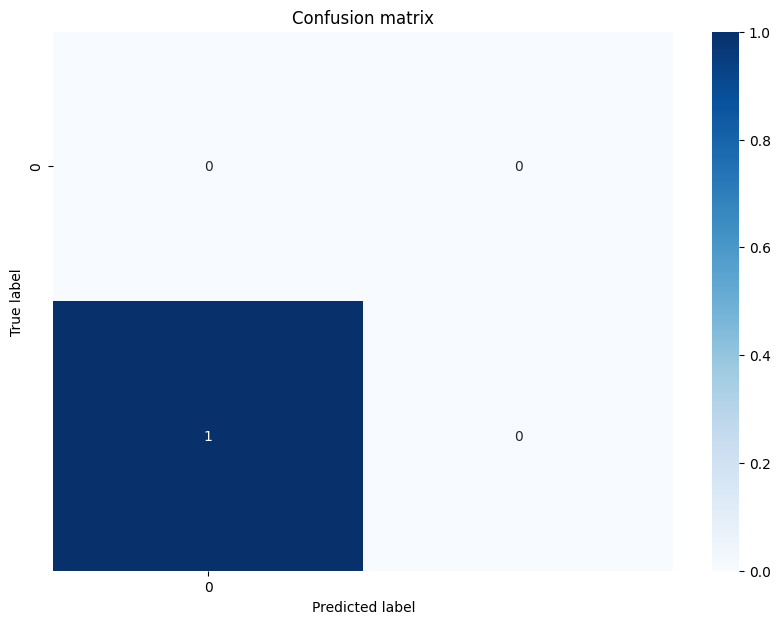

In [ ]:
modelss('HS')


Epoch 1 / 1:
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Evaluating...
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Training Loss: 0.022
Validation Loss: 0.022
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



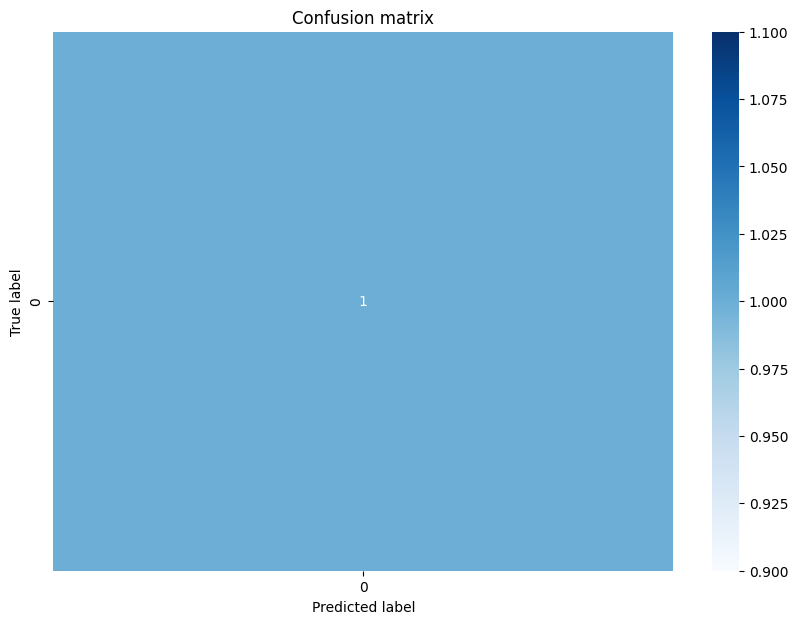

In [ ]:
modelss('AG')


Epoch 1 / 1:
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Evaluating...
Batch 1/1 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Training Loss: 0.022
Validation Loss: 0.023
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

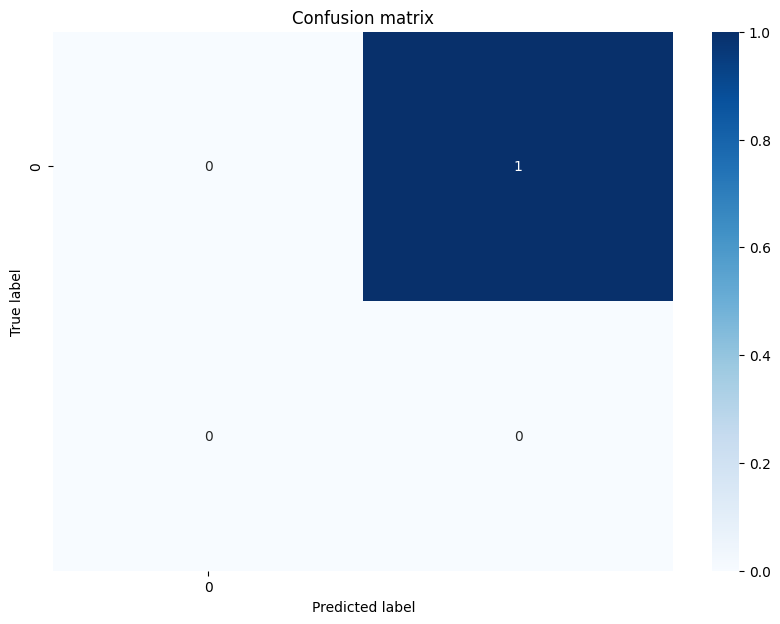

In [ ]:
modelss('TR')

In [ ]:
# Load test data
testdf = pd.read_csv('/content/hate_speech_dataset_sample(size 10).csv')
test_data = pre_process_dataset(testdf['text'].tolist())

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-base-uncased')

# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame({'id': testdf['id']})

# Define the labels
labels = ['HS', 'TR', 'AG']

# Iterate over each label
for label in labels:
    # Load the corresponding model
    model_path = f'model_{label}.pth'
    model = BERT_LSTM_Model(bert, 2)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    # Tokenize the test data
    test_seq = torch.tensor([tokenizer.encode(i, max_length=36, pad_to_max_length=True) for i in test_data])
    test_mask = torch.tensor([[float(i > 0) for i in ii] for ii in test_seq])

    # Get predictions for test data
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    # Get the predicted labels
    predictions_df[label] = np.argmax(preds, axis=1)

# Apply conditions to the predictions
predictions_df['TR'] = predictions_df.apply(lambda row: row['TR'] if row['HS'] == 1 else 0, axis=1)
predictions_df['AG'] = predictions_df.apply(lambda row: row['AG'] if row['HS'] == 1 else 0, axis=1)

# Round the predictions to binary values (0 or 1)
predictions_df = predictions_df.round().astype(int)

# Save the predictions to a CSV file
predictions_df.to_csv('prediction_2.csv', index=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning

In [ ]:
# Load test data
testdf = pd.read_csv('/content/hate_speech_dataset_sample(size 10).csv')
test_data = pre_process_dataset(testdf['text'].tolist())

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-base-uncased')

# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame({'id': testdf['id']})

# Define the labels
labels = ['HS', 'TR', 'AG']

# Iterate over each label
for label in labels:
    # Load the corresponding model
    model_path = f'model_{label}.pth'
    model = BERT_LSTM_Model(bert, 2)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    # Tokenize the test data
    test_seq = torch.tensor([tokenizer.encode(i, max_length=36, pad_to_max_length=True) for i in test_data])
    test_mask = torch.tensor([[float(i > 0) for i in ii] for ii in test_seq])

    # Get predictions for test data
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    # Get the predicted labels
    predictions_df[label] = np.argmax(preds, axis=1)

# Apply conditions to the predictions
predictions_df['TR'] = predictions_df.apply(lambda row: row['TR'] if row['HS'] == 1 else 0, axis=1)
predictions_df['AG'] = predictions_df.apply(lambda row: row['AG'] if row['HS'] == 1 else 0, axis=1)

# Round the predictions to binary values (0 or 1)
predictions_df = predictions_df.round().astype(int)

# Save the predictions to a CSV file
predictions_df.to_csv('prediction_2.csv', index=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning